# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import nullcontext

In [2]:
df = pd.read_csv("facial-keypoints-detection/training.csv")

In [3]:
y_full = df.drop(columns=["Image"]).values.astype(np.float32)
x_full = [[int(n) for n in img_str.split()] for img_str in df["Image"]]
x_full = np.array(x_full, dtype=np.float32).reshape((-1, 1, 96, 96)) / 255

In [4]:
def multi_plot(imgs, key_point_sets, cols=4, title=None):
    n = len(imgs)
    rows = (n + cols - 1) // cols
    if title:
        plt.title(title)
        plt.axis('off')
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i], cmap="grey")
        key_points = key_point_sets[i].reshape((-1, 2))
        key_points *= imgs.shape[1] / 96
        plt.axis('off')
        plt.scatter(key_points[:, 0], key_points[:, 1], s=8, c="lime")
    plt.tight_layout()
    plt.show()

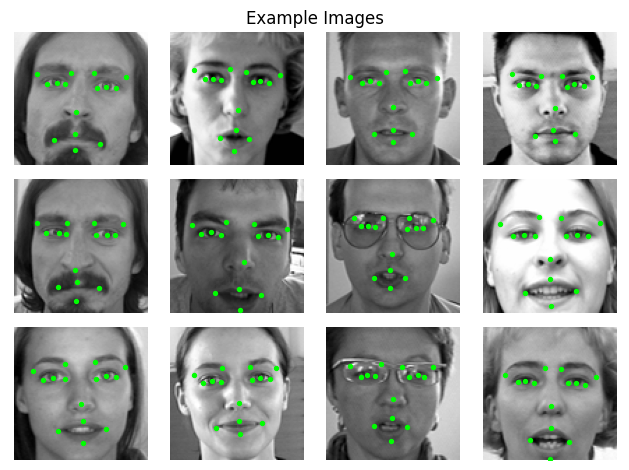

In [5]:
multi_plot(x_full[:12, 0], y_full[:12], title="Example Images")

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_full, 
    y_full,
    test_size=0.125,
    shuffle=True,
    random_state=0,
)

imputer = KNNImputer()
y_train_full = imputer.fit_transform(y_train_full)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, 
    y_train_full,
    test_size=0.15,
    shuffle=True,
    random_state=0,
)

print(f"{len(x_train)} train, {len(x_val)} val, {len(x_test)} test")

5241 train, 926 val, 882 test


# Default Model

In [7]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [8]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

compile_model = device == "cpu" or device == "cuda"

context = torch.autocast(device) if device == "cuda" else nullcontext()

In [9]:
def np2torch(x, device=device):
    return torch.from_numpy(x).to(device)


def torch2np(x):
    return x.detach().cpu().numpy()

In [10]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 30)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.reshape((-1, 9216))
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [11]:
def batch_iterate(x, y, batch_size, device=device):
    permutation = np.random.permutation(y.shape[0])
    for s in range(0, y.shape[0], batch_size):
        idxs = permutation[s:s + batch_size]
        yield np2torch(x[idxs], device), np2torch(y[idxs], device)

In [12]:
def evaluate(model, x, y, device=device):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        var = torch.mean(torch.square(y - torch.mean(y, dim=0))).item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f"loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}")

In [13]:
default_model = CNN().to(device)
if compile_model:
    default_model = torch.compile(default_model)

optimizer = optim.Adam(default_model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [14]:
# default_model.train()

# for epoch in range(200):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)

#     for x, y in batch_iterate(x_train, y_train, batch_size=100):
#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(default_model(x), y)
#         loss.backward()
#         optimizer.step()

#     scheduler.step()
    
# torch.save(default_model.state_dict(), "checkpoints/default_model0.pth")

In [15]:
default_model.load_state_dict(torch.load("checkpoints/default_model_good.pth"))

<All keys matched successfully>

In [16]:
print("train:", end="\n    ")
evaluate(default_model, x_train, y_train)
print("val:", end="\n    ")
evaluate(default_model, x_val, y_val)

train:
    loss: 3.218, R^2: 0.714
val:
    loss: 4.865, R^2: 0.568


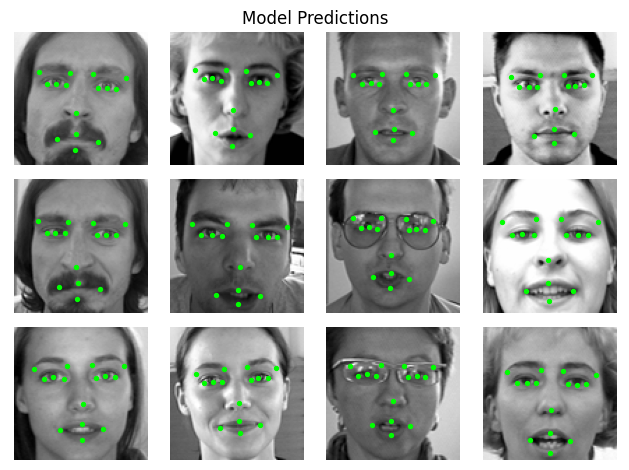

In [17]:
y_pred = torch2np(default_model(np2torch(x_full[:12])).clip(0, 95))
multi_plot(x_full[:12, 0], y_pred[:12], title="Model Predictions")

# Attacking the Model

In [18]:
def no_attack(model, x, y, eps):
    return torch.zeros_like(x)

In [19]:
def rand_sign(model, x, y, eps):
    return eps * torch.sign(torch.randn_like(x))

In [20]:
def fgsm(model, x, y, eps):
    delta = torch.zeros_like(x, requires_grad=True)
    with context:
        loss = F.mse_loss(model(x + delta), y)
    loss.backward()
    return eps * torch.sign(delta.grad)

In [21]:
def pgd(model, x, y, eps, alpha=0.5, n_iters=50):
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(n_iters):
        with context:
            loss = F.mse_loss(model(x + delta), y)
        loss.backward()
        with torch.no_grad():
            delta += alpha * delta.grad
            delta.clip_(-eps, eps)
            delta.grad.zero_()
    return delta.detach()

In [22]:
def evaluate_attack(attack_fn, model, x, y, eps, device=device):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for bx, by in batch_iterate(x, y, batch_size=100, device=device):
        bx += attack_fn(model, bx, by, eps)
        y_pred = model(bx)
        loss = F.mse_loss(y_pred, by).item()
        var = torch.square(by - by.mean(dim=0)).mean().item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f"loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}")

In [23]:
def plot_attack_example(attack_fn, model, x, y, eps):
    delta = attack_fn(model, np2torch(x[:12]), np2torch(y[:12]), eps)
    y_pred = torch2np(model(np2torch(x[:12]) + delta).clip(0, 95))
    title = "".join([c if c != '_' else ' ' for c in attack_fn.__name__]).upper()
    multi_plot(x[:12, 0] + torch2np(delta)[:12, 0], y_pred[:12], title=title + " Attack")

In [24]:
print("no attack:", end="\n    ")
evaluate(default_model, x_val, y_val)
print("random sign attack:", end="\n    ")
evaluate_attack(rand_sign, default_model, x_val, y_val, 0.01)
print("fgsm attack:", end="\n    ")
evaluate_attack(fgsm, default_model, x_val, y_val, 0.01)
print("pgd attack:", end="\n    ")
evaluate_attack(pgd, default_model, x_val, y_val, 0.01)

no attack:
    loss: 4.660, R^2: 0.571
random sign attack:
    loss: 4.763, R^2: 0.544
fgsm attack:
    loss: 29.189, R^2: -1.831
pgd attack:
    loss: 65.094, R^2: -5.432


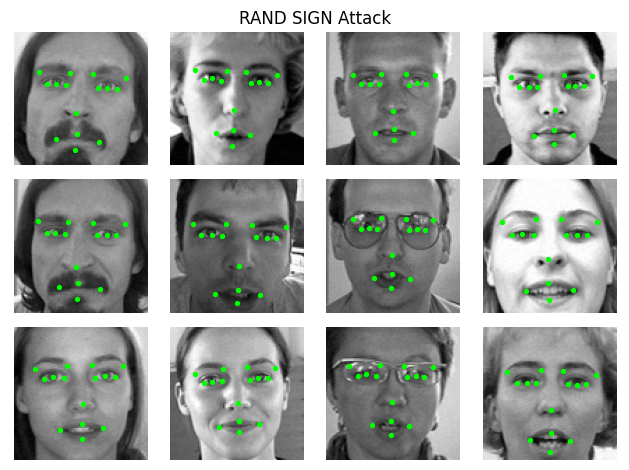

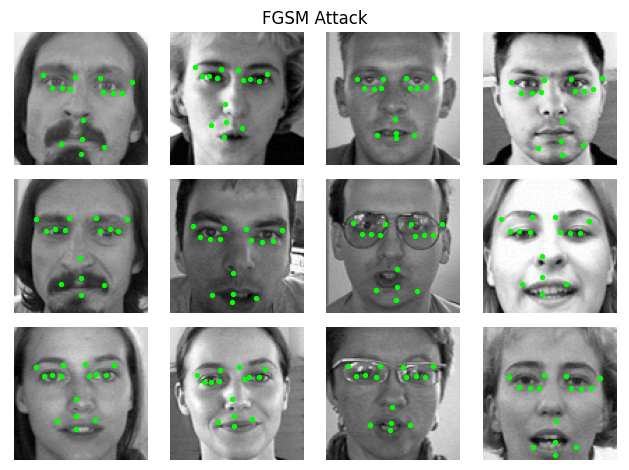

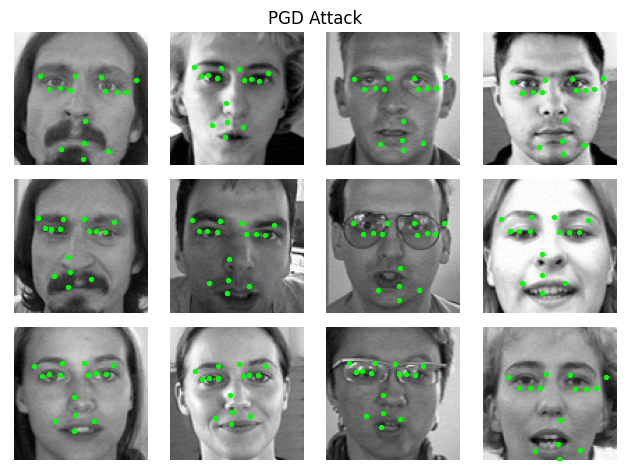

In [25]:
plot_attack_example(rand_sign, default_model, x_full, y_full, 0.01)
plot_attack_example(fgsm, default_model, x_full, y_full, 0.01)
plot_attack_example(pgd, default_model, x_full, y_full, 0.01)

# Robust Model for Random Sign Attack

In [26]:
robust_model_rs = CNN().to(device)
if compile_model:
    robust_model_rs = torch.compile(robust_model_rs)

optimizer = optim.Adam(robust_model_rs.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [27]:
# robust_model_rs.train()

# eps = 0.005

# for epoch in range(200):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)

#     for x, y in batch_iterate(x_train, y_train, batch_size=100):
#         x += rand_sign(robust_model_rs, x, y, eps)
#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_rs(x), y)
#         loss.backward()
#         optimizer.step()

#     eps += 0.0001
#     scheduler.step()
    
# torch.save(robust_model_rs.state_dict(), "checkpoints/robust_model_rs0.pth")

In [28]:
robust_model_rs.load_state_dict(torch.load("checkpoints/robust_model_rs_good.pth"))

<All keys matched successfully>

In [29]:
print("no attack:", end="\n    ")
evaluate(robust_model_rs, x_val, y_val)
print("random sign attack:", end="\n    ")
evaluate_attack(rand_sign, robust_model_rs, x_val, y_val, 0.01)
print("fgsm attack:", end="\n    ")
evaluate_attack(fgsm, robust_model_rs, x_val, y_val, 0.01)
print("pgd attack:", end="\n    ")
evaluate_attack(pgd, robust_model_rs, x_val, y_val, 0.01)

no attack:
    loss: 5.005, R^2: 0.541
random sign attack:
    loss: 4.839, R^2: 0.552
fgsm attack:
    loss: 30.466, R^2: -2.035
pgd attack:
    loss: 64.407, R^2: -5.282


# Robust Model for FGSM Attack

In [30]:
robust_model_fgsm = CNN().to(device)
if compile_model:
    robust_model_fgsm = torch.compile(robust_model_fgsm)

optimizer = optim.Adam(robust_model_fgsm.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [31]:
# robust_model_fgsm.train()

# eps = 0.005
# batch_size = 100
# delta = torch.zeros((batch_size, 1, 96, 96), requires_grad=True, device=device)

# for epoch in range(100):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)
        
#     for x, y in batch_iterate(x_train, y_train, batch_size=batch_size):
#         if len(x) != batch_size:
#             continue

#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_fgsm(x + delta), y)
#         loss.backward()
#         optimizer.step()

#         with torch.no_grad():
#             x += eps * delta.grad.sign_()
#             delta.grad.zero_()

#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_fgsm(x), y)
#         loss.backward()
#         optimizer.step()
    
#     eps += 0.0001
#     scheduler.step()
    
# torch.save(robust_model_fgsm.state_dict(), "checkpoints/robust_model_fgsm0.pth")

In [32]:
robust_model_fgsm.load_state_dict(torch.load("checkpoints/robust_model_fgsm_good.pth"))

<All keys matched successfully>

In [33]:
print("no attack:", end="\n    ")
evaluate(robust_model_fgsm, x_val, y_val)
print("random sign attack:", end="\n    ")
evaluate_attack(rand_sign, robust_model_fgsm, x_val, y_val, 0.01)
print("fgsm attack:", end="\n    ")
evaluate_attack(fgsm, robust_model_fgsm, x_val, y_val, 0.01)
print("pgd attack:", end="\n    ")
evaluate_attack(pgd, robust_model_fgsm, x_val, y_val, 0.01)

no attack:
    loss: 4.324, R^2: 0.593
random sign attack:
    loss: 4.362, R^2: 0.593
fgsm attack:
    loss: 8.632, R^2: 0.317
pgd attack:
    loss: 13.794, R^2: -0.355


# Robust Model for PGD Attack

In [34]:
def pgd_loss(model, x, y, eps, device=device):
    model.eval()
    loss_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        x += pgd(model, x, y, eps)
        y_pred = model(x)
        with context:
            loss = F.mse_loss(y_pred, y).item()
        loss_sum += loss
        n_batches += 1
    return loss_sum / n_batches

In [35]:
robust_model_pgd = CNN().to(device)
robust_model_pgd.load_state_dict(torch.load("checkpoints/robust_model_fgsm_good.pth"))
if compile_model:
    robust_model_pgd = torch.compile(robust_model_pgd)

optimizer = optim.Adam(robust_model_pgd.parameters(), lr=0.0001, weight_decay=0.1)

In [36]:
# robust_model_pgd.train()

# eps = 0.01
# epochs_per_pgd_training = 5

# best_pgd_val_loss = pgd_loss(robust_model_pgd, x_val, y_val, eps)
# print(f"before pgd training, loss: {best_pgd_val_loss:.3f}")

# for epoch in range(100):
#     for x, y in batch_iterate(x_train, y_train, batch_size=100):
#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_pgd(x), y)
#         loss.backward()
#         optimizer.step()

#         x += pgd(robust_model_pgd, x, y, eps)
#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_pgd(x), y)
#         loss.backward()
#         optimizer.step()
    
#     if (epoch + 1) % 5 == 0:
#         pgd_val_loss = pgd_loss(robust_model_pgd, x_val, y_val, eps)
#         print(f"epoch {epoch + 1}, loss: {pgd_val_loss:.3f}")
#         if pgd_val_loss < best_pgd_val_loss:
#             best_pgd_val_loss = pgd_val_loss
#             torch.save(robust_model_pgd.state_dict(), "checkpoints/robust_model_pgd0.pth")
#             print("    model saved")
#         else:
#             break

In [37]:
robust_model_pgd.load_state_dict(torch.load("checkpoints/robust_model_pgd_good.pth"))

<All keys matched successfully>

In [38]:
print("no attack:", end="\n    ")
evaluate(robust_model_pgd, x_val, y_val)
print("random sign attack:", end="\n    ")
evaluate_attack(rand_sign, robust_model_pgd, x_val, y_val, 0.01)
print("fgsm attack:", end="\n    ")
evaluate_attack(fgsm, robust_model_pgd, x_val, y_val, 0.01)
print("pgd attack:", end="\n    ")
evaluate_attack(pgd, robust_model_pgd, x_val, y_val, 0.01)

no attack:
    loss: 4.082, R^2: 0.632
random sign attack:
    loss: 4.071, R^2: 0.629
fgsm attack:
    loss: 6.294, R^2: 0.406
pgd attack:
    loss: 6.086, R^2: 0.440


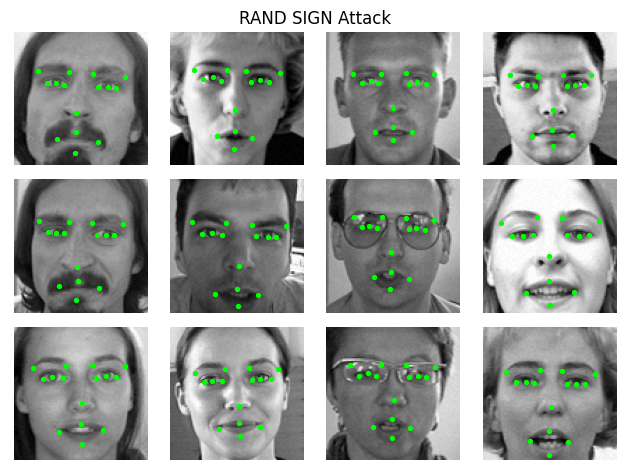

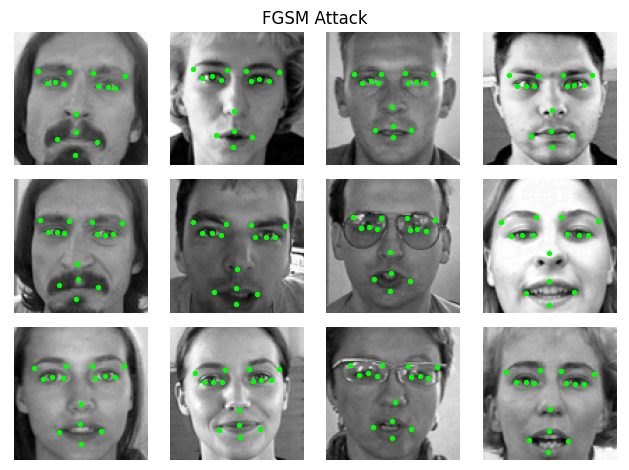

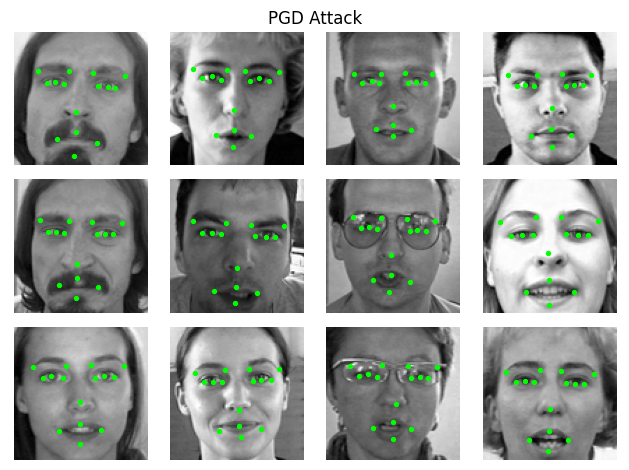

In [39]:
plot_attack_example(rand_sign, robust_model_pgd, x_full, y_full, 0.01)
plot_attack_example(fgsm, robust_model_pgd, x_full, y_full, 0.01)
plot_attack_example(pgd, robust_model_pgd, x_full, y_full, 0.01)

# Testing

In [40]:
model_names = [
    "default_model", 
    "robust_model_fgsm",
    "robust_model_pgd",
]

models = []
for name in model_names:
    model = CNN().to(device)
    model.load_state_dict(torch.load(f"checkpoints/{name}_good.pth"))
    if compile_model:
        model = torch.compile(model)
    models.append(model)


attack_fn_names = ["rand_sign", "fgsm", "pgd"]
attack_fns = [rand_sign, fgsm, pgd]

In [41]:
def evaluate_r2_safe(attack_fn, model, x, y, eps, device=device):
    model.eval()
    r2_sum = 0
    cnt = 0
    for bx, by in batch_iterate(x, y, batch_size=100, device=device):
        bx += attack_fn(model, bx, by, eps)
        y_pred = model(bx)
        for i in range(by.shape[1]):
            ok_idxs = ~by[:, i].isnan()
            by_ok = by[ok_idxs, i]
            y_pred_ok = y_pred[ok_idxs, i]
            loss = F.mse_loss(y_pred_ok, by_ok).item()
            var = torch.square(by_ok - by_ok.mean()).mean().item()
            r2_sum += 1 - loss / var
            cnt += 1

    return r2_sum / cnt

In [42]:
val_results = {}
eps_range = np.logspace(-4, -1, num=10)

for i, model in enumerate(models):
    val_results[model_names[i]] = {}
    for j, attack_fn in enumerate(attack_fns):
        r2 = [evaluate_r2_safe(attack_fn, model, x_val, y_val, eps) for eps in eps_range]
        val_results[model_names[i]][attack_fn_names[j]] = r2

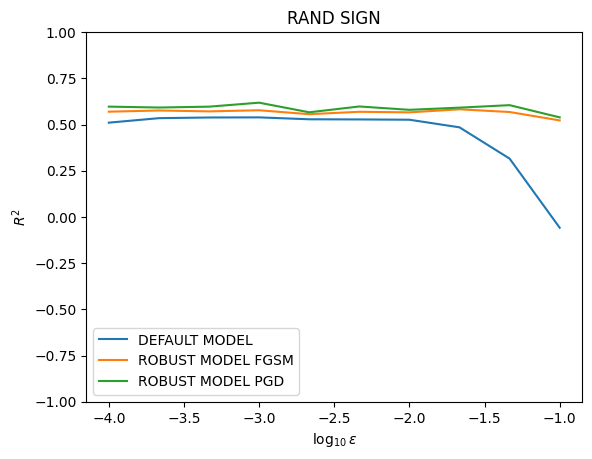

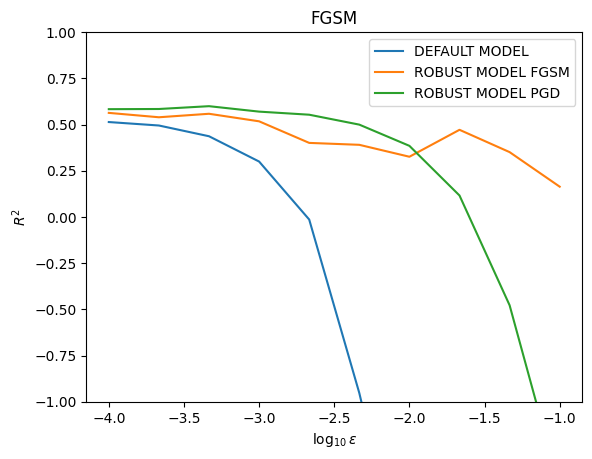

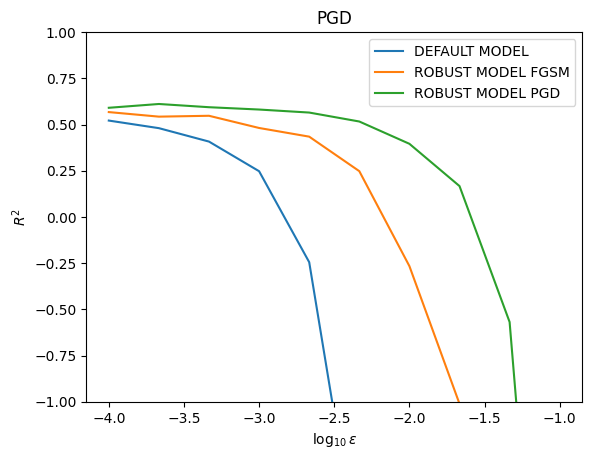

In [49]:
for attack_name in attack_fn_names:
    plt.figure()
    for model_name in model_names:
        label = "".join([c if c != '_' else ' ' for c in model_name]).upper()
        plt.plot(np.log10(eps_range), val_results[model_name][attack_name], label=label)
    plt.title("".join([c if c != '_' else ' ' for c in attack_name]).upper())
    plt.legend()
    plt.xlabel("$\log_{10}\epsilon$")
    plt.ylabel("$R^2$")
    plt.ylim(-1, 1)
    plt.show()

In [44]:
test_results = {}
eps_range = np.logspace(-4, -1, num=10)

for i, model in enumerate(models):
    test_results[model_names[i]] = {}
    for j, attack_fn in enumerate(attack_fns):
        r2 = [evaluate_r2_safe(attack_fn, model, x_test, y_test, eps) for eps in eps_range]
        test_results[model_names[i]][attack_fn_names[j]] = r2

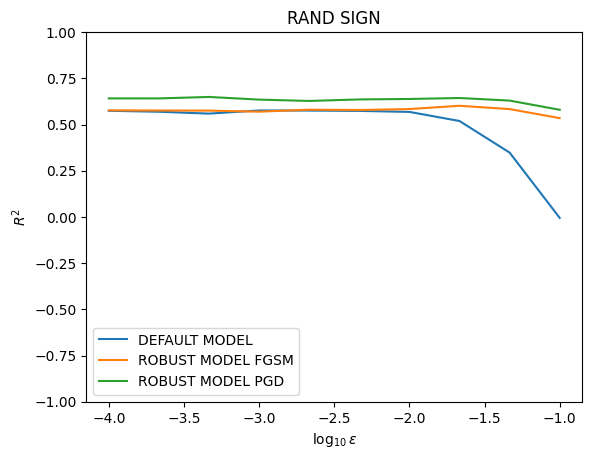

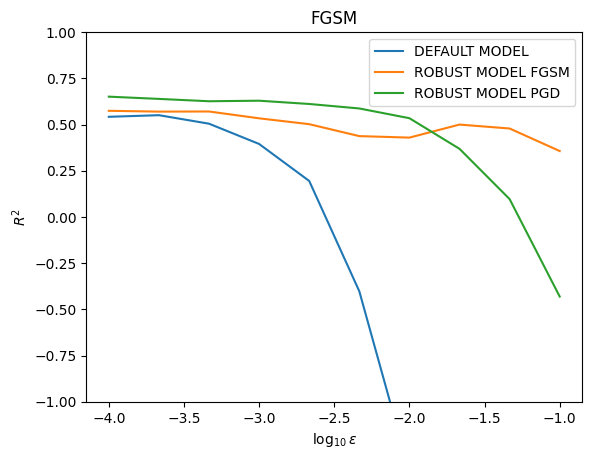

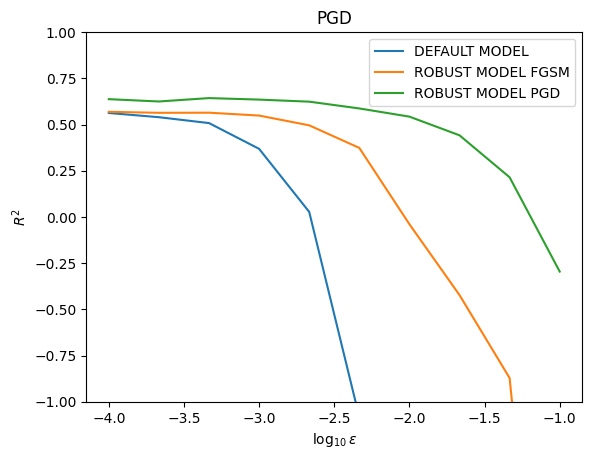

In [50]:
for attack_name in attack_fn_names:
    plt.figure()
    for model_name in model_names:
        label = "".join([c if c != '_' else ' ' for c in model_name]).upper()
        plt.plot(np.log10(eps_range), test_results[model_name][attack_name], label=label)
    plt.title("".join([c if c != '_' else ' ' for c in attack_name]).upper())
    plt.legend()
    plt.xlabel("$\log_{10}\epsilon$")
    plt.ylabel("$R^2$")
    plt.ylim(-1, 1)
    plt.show()